Importo librerías, gráficos y el mallado:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gmsh

In [2]:
# estoy revisando en remote

In [3]:
plt.rc('figure', figsize=(18,9))
plt.rc('font', size=22)
def plot_forces_wmpl(mn, f, ax=None, fig=None, scalex=None, scaley=None):
    if ax is  None:
        fig,ax = plt.subplots()
    selection = (np.abs(f[:,0]) > 0) | (np.abs(f[:,1])>0)
    plt.quiver(mn[selection,0], mn[selection,1], f[selection,0], np.zeros_like(f[selection,0]),scale=scalex, scale_units='x')
    plt.quiver(mn[selection,0], mn[selection,1], np.zeros_like(f[selection,1]), f[selection,1],scale=scaley, scale_units='y')
    return fig, ax

def plot_stress_wmpl(mn, mc, stress, label, ax=None, fig=None):
    if ax is None:
        fig, ax = plt.subplots()
    mapp = ax.tripcolor(mn[:,0], mn[:,1], mc, facecolors=stress)
    cbar = plt.colorbar(mapp, ax=ax)
    cbar.set_label(label)
    return fig, ax

#mdfcomment gmsh.fltk.run() estoy revisando en remote
def mpl_mesh_plot(mn, mc):
    fig, ax = plt.subplots()
    ax.triplot(mn[:,0], mn[:,1], mc)
    return fig, ax


Cargo los datos del problema:

In [4]:
n=0.3 #Coeficiente de poisson
E=30E6 #En Psi
t=1 #Espesor en pulgadas
largo=20 #En pulgadas
altura=10 #En pulgadas
T=1000 #[PSI]

Armo la chapa con el agujero:

In [5]:
gmsh.initialize() #Abre el programa en phyton
gmsh.model.add('chapa con agujero') #Armamos el modelo que vamos modificar

Info    : Increasing process stack size (8192 kB < 16 MB)


Puntos de interés:

In [6]:
lc=0.3 #Factor de escala, lo utilizo para controlar el mallado.

#Se puede resolver 1/4 de la chapa porque el problema es simetrico por lo que se armará sólo esa sección:

p1 = gmsh.model.geo.addPoint(0, 0, 0,lc)
p2 = gmsh.model.geo.addPoint(0, altura/2, 0,lc)
p3 = gmsh.model.geo.addPoint(largo/2, altura/2, 0,lc) 
p4 = gmsh.model.geo.addPoint(largo/2, 0, 0,lc)
p5 = gmsh.model.geo.addPoint(0,1,0,lc/15)
p6 = gmsh.model.geo.addPoint(1,0,0,lc/15)

Líneas de geometría:

In [7]:
l1 = gmsh.model.geo.addLine(p5, p2)
l2 = gmsh.model.geo.addLine(p2, p3)
l3 = gmsh.model.geo.addLine(p3, p4)
l4 = gmsh.model.geo.addLine(p4, p6)
l5= gmsh.model.geo.addCircleArc(p5,p1,p6)  #Creo una parte circular

C1 = gmsh.model.geo.addCurveLoop([l1, l2, l3, l4])
C2 = gmsh.model.geo.addCurveLoop([l5])

Superficie:

In [8]:
S1 = gmsh.model.geo.addPlaneSurface([C1,C2]) #asi se genera la superifice descontando el circulo

In [9]:
gmsh.model.geo.synchronize() #Vuelve a sincronizar

Grupos físicos:

In [10]:
Empotradoy=gmsh.model.addPhysicalGroup(1,[l4])
gmsh.model.setPhysicalName(1,Empotradoy,'Empotrado y')

Traccionado=gmsh.model.addPhysicalGroup(1,[l3])
gmsh.model.setPhysicalName(1,Traccionado,'Traccionado')

Empotradox=gmsh.model.addPhysicalGroup(1,[l1])
gmsh.model.setPhysicalName(1,Empotradox,'Empotrado x')

Superficie = gmsh.model.addPhysicalGroup(2,[S1])
gmsh.model.setPhysicalName(2,Superficie, 'Superficie')

NodoAgujero= gmsh.model.addPhysicalGroup(0, [p1])
gmsh.model.setPhysicalName(0, NodoAgujero, 'Nodo agujero')

Genero el mallado:

In [11]:
gmsh.model.mesh.generate(2)
# gmsh.fltk.run() estoy revisando en remote

Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 20%] Meshing curve 2 (Line)
Info    : [ 40%] Meshing curve 3 (Line)
Info    : [ 60%] Meshing curve 4 (Line)
Info    : [ 80%] Meshing curve 5 (Circle)
Info    : Done meshing 1D (Wall 0.00871229s, CPU 0.023611s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.0643638s, CPU 0.099796s)
Info    : 3147 nodes 6296 elements


Obtengo información relevante sobre los nodos:

In [12]:
NodeInfo = gmsh.model.mesh.get_nodes()
NumeroNodos=NodeInfo[0].shape[0]
MN=NodeInfo[1].reshape(NumeroNodos,3)

Obtengo información relevante sobre los elementos:

In [13]:
ETAGS,ELEMENTS=gmsh.model.mesh.get_elements_by_type(2) #Triángulos.
MC=ELEMENTS.reshape([ETAGS.shape[0],3])
MC=(MC-1).astype(int)
print('La cantidad de elementos es',len(MC))

La cantidad de elementos es 6033


In [14]:
# estoy revisando en remote

(<Figure size 1296x648 with 1 Axes>, <AxesSubplot:>)

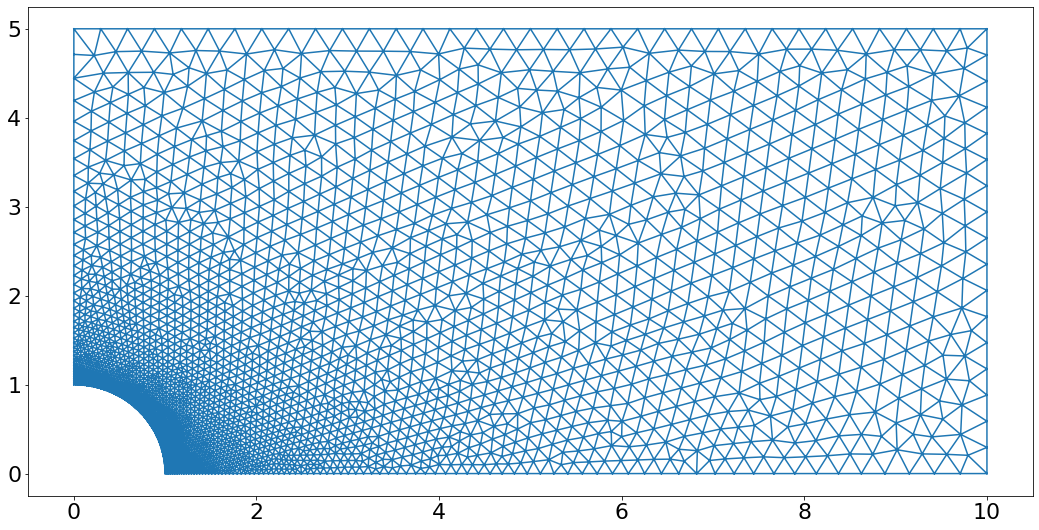

In [15]:
mpl_mesh_plot(MN, MC)

Defino empotrado:

In [16]:
NodosEmpotrados=gmsh.model.mesh.get_nodes_for_physical_group(1,Empotradox)
NodosEmpotrados2=gmsh.model.mesh.get_nodes_for_physical_group(1,Empotradoy)

s1=NodosEmpotrados[0].reshape(len(NodosEmpotrados[0]),1) #Etiquetas de los nodos empotrados
s2=NodosEmpotrados2[0].reshape(len(NodosEmpotrados2[0]),1) #Etiquetas de los nodos empotrados 2 
S=np.vstack((s1,s2))
z=np.zeros([len(NodosEmpotrados[0])+len(NodosEmpotrados2[0]),2])
MNE=np.concatenate((S-1,z),axis=1) #Indices en python
MNE=MNE.astype(int)

Defino tracción:

In [17]:
NodosTraccionados=gmsh.model.mesh.get_nodes_for_physical_group(1,Traccionado)

s=NodosTraccionados[0].reshape(len(NodosTraccionados[0]),1).astype(int) #Etiquetas de los nodos traccionados
z=np.zeros([len(NodosTraccionados[0]),2]).astype(int)
MNT=np.concatenate((s-1,z),axis=1) #Indices en python

In [18]:
#El desplazamiento nulo  a: Borde izquierdo (solo en x), Borde inferior (solo en y) ,Punto del medio de la chapa (en x e y)

agujero1 = 2 * (gmsh.model.mesh.get_nodes_for_physical_group(0,NodoAgujero)[0] - 1).astype(int)
agujero2 = (2 * (gmsh.model.mesh.get_nodes_for_physical_group(0,NodoAgujero)[0] - 1) + 1).astype(int)
Smx = 2 * (gmsh.model.mesh.get_nodes_for_physical_group(1,Empotradox)[0] - 1).astype(int)
Smy = (2 * (gmsh.model.mesh.get_nodes_for_physical_group(1,Empotradoy)[0] - 1) +1).astype(int)

In [19]:
entityTraccionada=gmsh.model.getEntitiesForPhysicalGroup(1,Traccionado)
Tgroup,Ttraccionada,Ltraccionada=gmsh.model.mesh.getElements(1,entityTraccionada[0])
Ltraccionada=Ltraccionada[0].reshape(Ttraccionada[0].shape[0],2) #Matriz de conectividad del extremo traccionado

#Para distribuir la tension en los elementos de la linea derecha:

Longitudes=np.abs(MN[Ltraccionada[:,0]-1,1]-MN[Ltraccionada[:,1]-1,1])
Tension_ext=T/(altura)

#Fuerzas sobre la linea derecha:

for l,linea in enumerate(Ltraccionada-1):
    n1 = int(linea[0])   # el -1 es para numerar desde cero
    n2 = int(linea[1])
    flocal=Tension_ext*Longitudes[l]*t/2
    flocal=round(flocal)
    MNT[MNT[:,0]==n1,1] += flocal
    MNT[MNT[:,0]==n2,1] += flocal

Se termina de armar la chapa con agujero y procedemos a realizar los cálculos:

In [20]:
nb=len(MNE)
nc=len(MNT)
NN=len(MN)
print('el numero de nodos es',NN)

D=np.array([[1,n,0],
            [n,1,0],
            [0,0,0.5*(1-n)]] )*E/(1-n**2)

el numero de nodos es 3147


Armo la k global:

In [21]:
kglobal=np.zeros([NN*2,NN*2])
B=[]
for i in range (len(MC)):
    A=np.linalg.det([[1,MN[MC[i,0],0],MN[MC[i,0],1]],
                    [1,MN[MC[i,2],0],MN[MC[i,2],1]],
                    [1,MN[MC[i,1],0],MN[MC[i,1],1]]])/2
    
    
    betai=MN[MC[i,2],1]-MN[MC[i,1],1]
    gammai=MN[MC[i,1],0]-MN[MC[i,2],0]
    
    betaj=MN[MC[i,1],1]-MN[MC[i,0],1]
    gammaj=MN[MC[i,0],0]-MN[MC[i,1],0]
    
    betam=MN[MC[i,0],1]-MN[MC[i,2],1]
    gammam=MN[MC[i,2],0]-MN[MC[i,0],0]
    
    B.append(np.array([[betai,0,betaj,0,betam,0],
                       [0,gammai,0,gammaj,0,gammam],
                       [gammai,betai,gammaj,betaj,gammam,betam]])*(1/(2*A)))
    

    k= t * abs(A) * (np.dot(np.transpose(B[i]), np.dot(D,B[i])))
    
    i,m,j = MC[i,:]    
    index=np.array([i*2,i*2+1,j*2,j*2+1,m*2,m*2+1])
    kglobal[np.ix_(index,index)]+=k

Condiciones de contorno:

In [22]:
#f[i,0]=1 se conoce la fuerza
#f[i,0]=0 no se conoce la fuerza
#f[i,1]=valor, su valor estara en la segunda columna.

f=np.zeros([2*NN,2])

# introduzco a la matriz f las fuerzas conocidas

for i in range (nc):
    s=MNT[i,0]
    f[2*s,0]=1
    f[2*s,1]=MNT[i,1]
    f[2*s+1,0]=1
    f[2*s+1,1]=MNT[i,2]
    
# introduzco al vector f las fuerzas que son 0 porque no conozco su desplazamiento

for j in range (nb):
    if MNE[j,1]==1:
        s=MNE[j,0]
        f[2*s,0]=1
        f[2*s,1]=0
    if MNE[j,2]==1:
        s=MNE[j,0]
        f[2*s+1,0]=1
        f[2*s+1,1]=0
        
        
x=np.arange(NN) 
x=np.delete(x,[np.concatenate((MNE[:,0].astype(int),MNT[:,0].astype(int)))]) #tiene adentro los nodos en los que no se pusieron condiciones
       

<div style="background:#999900">no entiendo, qué sería esto ?</div>

In [23]:
if nb+nc <NN:
    f[2*x,0]=1
    f[2*x,1]=0
    f[2*x+1,0]=1
    f[2*x+1,1]=0

In [24]:
#El desplazamiento nulo a: Borde izquierdo (solo en x), Borde inferior (solo en y) ,Punto del medio de la chapa (en x e y)

indexd=np.sort( np.hstack((agujero1,agujero2,Smx,Smy)))
indexf = np.delete( np.arange(2*NumeroNodos) , indexd)

Selecciono componentes de Kglobal:

In [25]:
#Resuelvo [F]=[K'][u] como [K']^-1[F]=[u] teniendo K' las componentes seleccionadas según las fuerzas conocidas desde un principio:

desplazamientos=np.dot(np.linalg.inv(kglobal[np.ix_(indexf,indexf)]),f[indexf,1])

Creo vector desplazamientos:

In [26]:
d=np.zeros([2*NumeroNodos,2])
d[indexd,0]=1 
d[indexf,1]=desplazamientos
f[:,1]=np.dot(kglobal,d[:,1]) #Fuerzas faltantes

Calculo tensiones de los elementos:

In [27]:
tension=[] 

for s in range (len(MC)) :
    i,m,j = MC[s,:]    
    index=np.array([i*2,i*2+1,j*2,j*2+1,m*2,m*2+1])
    valor=np.dot(np.dot(B[s],d[index,1]),D)
    tension.append(valor)
    
tension = np.array(tension)

Calculo tensiones principales:

In [28]:
tensionmax=[]
tensionmin=[]

for p in range (len(tension)):
    maximo=(tension[p,0]+tension[p,1])/2+np.sqrt(((tension[p,0]-tension[p,1])/2)**2+tension[p,2]**2)
    minimo=(tension[p,0]+tension[p,1])/2-np.sqrt(((tension[p,0]-tension[p,1])/2)**2+tension[p,2]**2)

    tensionmax.append(maximo)
    tensionmin.append(minimo)  

tensionmax = np.array(tensionmax)
tensionmin = np.array(tensionmin)

#Utilizo el criterio Tresca, promediotens será mitad de la tension de fluencia:

promediotens=(tensionmax-tensionmin)/2

Desplazamientos:

In [29]:
Despx = d[:-1:2,1].reshape(-1,1)
Despy = d[1::2,1].reshape(-1,1)

Grafico final:

In [30]:
DESP=np.hstack((Despx,Despy,np.zeros([NumeroNodos,1])))
desps = gmsh.view.add("Desplazamientos")
Desps = gmsh.view.addModelData(desps, 0, 'chapa con agujero', 'NodeData', NodeInfo[0], DESP, numComponents=3)
Tensiones=gmsh.view.add('Tensiones')
Tensiones = gmsh.view.addModelData(Tensiones, 0, 'chapa con agujero', 'ElementData', ETAGS, promediotens.reshape(-1,1) , numComponents=1 )
print('La cantidad de elementos es',len(MC))
print('La cantidad de nodos es',NN)
# gmsh.fltk.run() estoy revisando en remote
gmsh.finalize()

La cantidad de elementos es 6033
La cantidad de nodos es 3147


<div style="background:#999900">no estas calculando las fuerzas ?</div>

In [31]:
DESP.shape

(3147, 3)

In [32]:
import pdb

(<Figure size 1296x648 with 2 Axes>, <AxesSubplot:>)

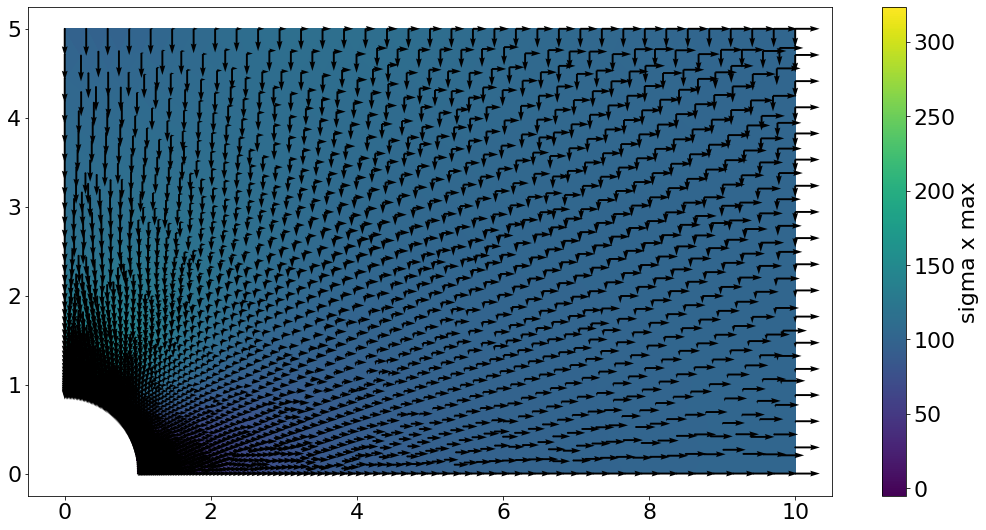

In [33]:
fig, ax  = plot_stress_wmpl(MN, MC, tensionmax, 'sigma x max')
plot_forces_wmpl(MN, DESP , ax =ax, fig=fig)